### Import packages

In [1]:
import numpy as np, pandas as pd, seaborn as sns,os,glob
from scipy import stats,optimize
from matplotlib import pyplot as plt, cm, colors
from matplotlib.gridspec import GridSpec as gs
import pickle as pk
from numpy import nan
from scipy.optimize import curve_fit
from adjustText import adjust_text
from scipy.stats import pearsonr

### Define helper functions

In [2]:
def zscore(data):
    return (data-data.mean())/data.std()
    
def remove_outliers(df,feature='length',zcutoff=3):
    df_copied = df.copy().reset_index(drop=True)
    data =df[feature].values
    data[np.isinf(data)] = np.percentile(data,99.9)*10
    data[np.isnan(data)] = np.percentile(data,0.01)/10
    zscores = zscore(data)
    in_range = np.where(np.abs(zscores)<zcutoff)[0]
    df_filtered = df_copied.iloc[in_range].copy().sort_values(by=feature).reset_index(drop=True)
    return df_filtered

def remove_outliers_batch(df,features = ['length'],zcutoffs = [3]):
    if len(features) != len(zcutoffs):
        raise ValueError("Feature and z-cutoff lists don't match")
    df_copy = df.copy()
    for f,z in zip(features,zcutoffs):
        df_copy = remove_outliers(df_copy,f,z)
    return df_copy

def min_max(data):
    return (data-data.min())/(data.max()-data.min())

### Load reference files

In [3]:
src = '/Users/saz462/Desktop/ClpTAC/Experiments/202306_BacPROTAC_flow_finalrun/'
ref = pd.read_excel('/Users/saz462/Desktop/ClpTAC/Experiments/Important_references/202402_Flow_well_keys_final.xlsx',sheet_name='merged')
ref_grouped = ref.groupby('Strain_id').max().copy()
ref_grouped['Target_gene'] = ['WT' if a=='WT' else b for a,b in ref_grouped[['Sample','Target_gene']].values]
ref_grouped['Target_gene'] = ['No Target' if a=='HW84' else b for a,b in ref_grouped[['Sample','Target_gene']].values]

In [4]:
csv_files = sorted(glob.glob(src+'202402_CSV_export_channel_values_final/*.csv'))

# step one, import well data with the highest numerical index
csv_dict = {}
for f in csv_files:
    _exp, _author, plate_time, date, well_id, _tail = f.split('/')[-1].split('_')
    plate, time = plate_time.split('-')
    well,sequence = well_id.split('.')
    unique_id = '{}_{}_{}_{}'.format(plate,time,well,date)
    if unique_id not in csv_dict:
        csv_dict[unique_id] = [int(sequence),pd.read_csv(f)]
    else:
        if int(sequence) > csv_dict[unique_id][0]:
            csv_dict[unique_id] = [int(sequence),pd.read_csv(f)]
            
# step two, concatenate all csv files
filtered = []
for k,v in csv_dict.items():
    df = v[1]
    df['Unique_id']=k
    plate,time,well,date = k.split('_')
    df['Plate']=plate
    df['Time']=time
    df['Well']=well
    df['Date']=date
    filtered.append(remove_outliers_batch(df,features=['AlexaFluor488-H'],zcutoffs = [3.5]))
    
filtered = pd.concat(filtered)
#filtered.to_csv('/Users/saz462/Desktop/ClpTAC/Experiments/202306_BacPROTAC_flow_finalrun/Notebooks/20240215_merged_channeldata.csv')

### Load saved data

In [4]:
filtered = pd.read_csv('/Users/saz462/Desktop/ClpTAC/Experiments/202306_BacPROTAC_flow_finalrun/Notebooks/20240215_merged_channeldata.csv')

### Group data

In [5]:
input_id = np.arange(1,25)
well_assignment = {}

for i,r in enumerate('ABCDEFGH'):
    for j,c in enumerate(np.arange(1,13)):
        w = '{}{}'.format(r,c)
        rep = int(i/4) + 1
        rapa = i%2
        strain = (i*12+j)%12+1+ int((i%4)/2)*12
        well_assignment[w] = [rep,rapa,strain]

rep_info = []
strain_info = []
rapa_info = []

grouped_median = filtered.groupby('Unique_id').median()
grouped_std = filtered.groupby('Unique_id').std()
grouped_max = filtered.groupby('Unique_id').max()

for p,w in grouped_max[['Plate','Well']].values:
    rep,rapa,_strain = well_assignment[w]
    strain = '{}_{}'.format(p,_strain)
    rep_info.append(rep)
    strain_info.append(strain)
    if rapa==0:
        rapa_info.append('DMSO')
    else:
        rapa_info.append('Rapa')
grouped_median['Rapa'] = rapa_info
grouped_median['Strain'] = strain_info
grouped_median['Replicate'] = rep_info
grouped_median['Plate']=grouped_max['Plate']
grouped_median['Time']=grouped_max['Time']
grouped_median['Well']=grouped_max['Well']
grouped_median['Date']=grouped_max['Date']
grouped_median['Time numeric'] = [int(x[1:]) for x in grouped_median['Time'].values]
grouped_median['AlexaFluor488-H-log'] = np.log2(grouped_median['AlexaFluor488-H'].values)
grouped_median[['Substrate','Locus']] = ref_grouped.loc[grouped_median['Strain'].values][['Target_gene','Locus_tag']].values
grouped_median.dropna(subset=['Substrate'], inplace=True)


/var/folders/vd/jc39n3k17jz_k0s88p5l1xrw0000gn/T/ipykernel_7256/3636502312.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_median = filtered.groupby('Unique_id').median()
/var/folders/vd/jc39n3k17jz_k0s88p5l1xrw0000gn/T/ipykernel_7256/3636502312.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_std = filtered.groupby('Unique_id').std()


### Calculate deg constant

/var/folders/vd/jc39n3k17jz_k0s88p5l1xrw0000gn/T/ipykernel_7256/978569662.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  deg_constant_dict['Plate{}-'.format(i)] = bg_subset[bg_subset['Rapa']=='DMSO'].copy().groupby('Time').mean().loc[['T0','T3','T6','T9','T12']]['AlexaFluor488-H'].values
/var/folders/vd/jc39n3k17jz_k0s88p5l1xrw0000gn/T/ipykernel_7256/978569662.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  deg_constant_dict['Plate{}+'.format(i)] = bg_subset[bg_subset['Rapa']=='Rapa'].copy().groupby('Time').mean().loc[['T0','T3','T6','T9','T12']]['AlexaFluor488-H'].values
/var/folders/vd/jc39n3k1

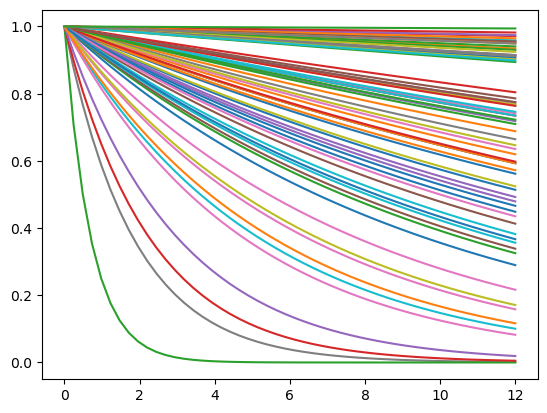

In [6]:
no_target_inhA_extras = ['Plate1_21', 'Plate2_19', 'Plate4_16']
dropped_substrates = ['MenB','FolE']


p0 = [1]
def unit_monoExp(x, t):
    return np.exp(-t * x)

xinterp=np.linspace(0,3.2,100)
fit_list = []

deg_constant_list = []
deg_constant_dict = {}
for i in range(1,7):
    bg_subset = grouped_median[(grouped_median['Plate']=='Plate{}'.format(i))&\
                               (grouped_median['Substrate']=='WT')]
    deg_constant_dict['Plate{}-'.format(i)] = bg_subset[bg_subset['Rapa']=='DMSO'].copy().groupby('Time').mean().loc[['T0','T3','T6','T9','T12']]['AlexaFluor488-H'].values
    deg_constant_dict['Plate{}+'.format(i)] = bg_subset[bg_subset['Rapa']=='Rapa'].copy().groupby('Time').mean().loc[['T0','T3','T6','T9','T12']]['AlexaFluor488-H'].values
    
for s in grouped_median['Strain'].unique():
    subset = grouped_median[grouped_median['Strain']==s].copy()
    plate = s.split('_')[0]
    substrate = subset['Substrate'].values[0]
    if (len(subset) == 20) and (subset['AlexaFluor488-H'].max()>610) and (s not in no_target_inhA_extras) and (substrate not in dropped_substrates):
        gene = subset['Locus'].values[0]
        v1 = subset[subset['Rapa']=='DMSO'].copy().groupby('Time').mean().loc[['T0','T3','T6','T9','T12']]['AlexaFluor488-H'].values
        v2 = subset[subset['Rapa']=='Rapa'].copy().groupby('Time').mean().loc[['T0','T3','T6','T9','T12']]['AlexaFluor488-H'].values
        if substrate=='MenB':
            v1[-1] = subset[(subset['Rapa']=='DMSO')&(subset['Time']=='T12')]['AlexaFluor488-H'].values.max()
        if substrate=='FolE':
            v2[0] = subset[(subset['Rapa']=='Rapa')&(subset['Time']=='T0')]['AlexaFluor488-H'].values.min()
        norm_v = (v2-deg_constant_dict['{}+'.format(plate)])/(v1-deg_constant_dict['{}-'.format(plate)])
        p,e = optimize.curve_fit(unit_monoExp,np.linspace(0,12,5),norm_v,p0=p0,bounds=[[0],[50]])
        #plt.plot(norm_v,label=substrate,color=cm.get_cmap('tab20')(i))
        plt.plot(np.linspace(0,12,50),unit_monoExp(np.linspace(0,12,50),p[0]))
        deg_constant_list.append([s,substrate,gene,p[0],np.log2(p[0]),v1[0],v2[0]]+list(norm_v))
deg_constant_list = pd.DataFrame(deg_constant_list,columns=['Strain','Substrate','Locus','Deg constant','log2(Deg constant)','T0-','T0+']+['T0','T3','T6','T9','T12']).sort_values(by='Deg constant', ascending=False).reset_index(drop=True)
deg_constant_list_pub = deg_constant_list[['Substrate','Locus','Deg constant','log2(Deg constant)','T0-','T0+','T0','T3','T6','T9','T12']].copy()


#deg_constant_list.to_excel('/Users/saz462/Desktop/ClpTAC/Experiments/202306_BacPROTAC_flow_finalrun/202402_Deg_stats_final.xlsx')
#deg_constant_list_pub.to_excel('/Users/saz462/Desktop/ClpTAC/Experiments/202306_BacPROTAC_flow_finalrun/202402_Deg_stats_final_pub.xlsx')

#deg_constant_list.to_excel('/Users/saz462/Desktop/ClpTAC/Experiments/Important_references/202402_Deg_stats_final.xlsx')
#deg_constant_list_pub.to_excel('/Users/saz462/Desktop/ClpTAC/Experiments/Important_references/202402_Deg_stats_final_pub.xlsx')

### Load deg constants

In [103]:
deg_constant_list = pd.read_excel('/Users/saz462/Desktop/ClpTAC/Experiments/Important_references/202402_Deg_stats_final.xlsx', index_col=0)
deg_constant_list_pub = pd.read_excel('/Users/saz462/Desktop/ClpTAC/Experiments/Important_references/202402_Deg_stats_final_pub.xlsx', index_col=0)

### Specify training set

In [7]:
deg_constant_list_sub = deg_constant_list[~deg_constant_list['Strain'].str.contains('Plate5')]

### Plot individual lineplots

In [8]:
lw = 3
colors = [np.array([121, 121, 121])/255, np.array([225, 60, 80])/255] #red and gray

for s in grouped_median['Substrate'].unique():
    fig = plt.figure(figsize=(3, 3))
    subset = grouped_median[grouped_median['Substrate'] == s].copy()
    if s == 'No Target':
        subset = grouped_median[(grouped_median['Substrate'] == s) & (grouped_median['Strain'] == 'Plate6_2')].copy()
    elif s == 'InhA':
        subset = grouped_median[(grouped_median['Substrate'] == s) & (grouped_median['Strain'] == 'Plate3_16')].copy()
    else:
        subset = grouped_median[grouped_median['Substrate'] == s].copy()

    lineplot = sns.lineplot(data=subset, x='Time numeric', y='AlexaFluor488-H', hue='Rapa', palette=colors, lw=lw, legend=False)
    scatter = sns.scatterplot(data=subset, x='Time numeric', y='AlexaFluor488-H', hue='Rapa', palette=colors, legend=True)
    plt.ylim(520, 850)
    plt.title(s)
    plt.xlabel('Time (h)')
    plt.xticks([0,3,6,9,12])
    
    handles, labels = scatter.get_legend_handles_labels()
    scatter.legend(handles=handles, labels=labels)
    
    #plt.savefig('/Users/saz462/Desktop/ClpTAC/Experiments/202306_BacPROTAC_flow_finalrun/Figures/202402_Lineplots/{}.svg'.format(s), bbox_inches='tight')
    plt.close()

### Plot all training set lineplots on a grid

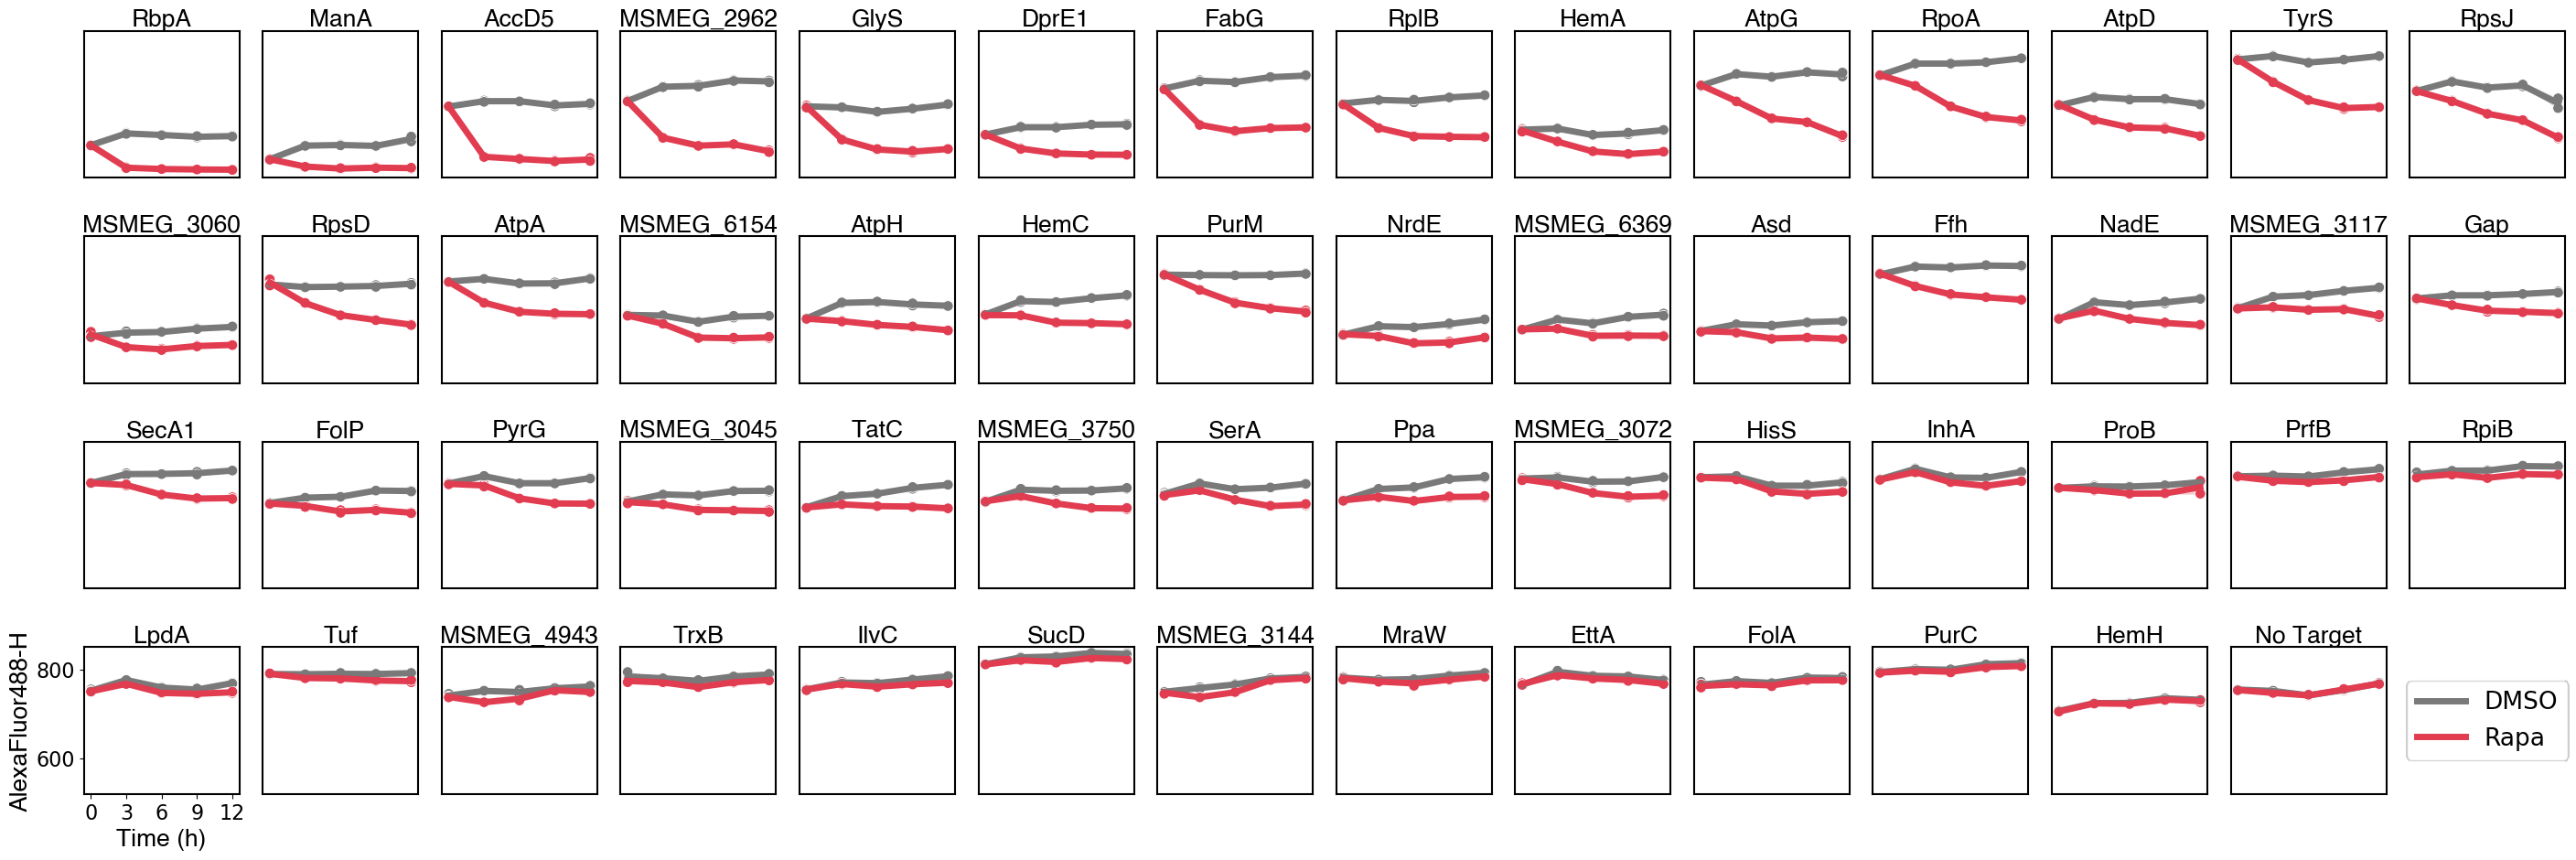

In [12]:
lw = 5
ps = 70
fs = 19

fig=plt.figure(figsize=(35,40))
grids= gs(14,14,hspace=0.4,wspace=0.15)
colors = [np.array([121, 121, 121])/255, np.array([225, 60, 80])/255] #red and gray

for i,k in enumerate(deg_constant_list_sub['Substrate'].unique()):
        
        # Determine row and column in grid
        r,c = (i//14),i%14
        ax=fig.add_subplot(grids[r,c])

        # Set the axis spine linewidth
        ax.spines[:].set_linewidth(1.5)

        # Define data based on substrate and define the No Target replicate to use
        if k == 'No Target':
            data = grouped_median[(grouped_median['Substrate'] == k) & (grouped_median['Strain'] == 'Plate6_2')].copy()
        elif k == 'InhA':
            data = grouped_median[(grouped_median['Substrate'] == k) & (grouped_median['Strain'] == 'Plate3_16')].copy()
        else:
            data = grouped_median[grouped_median['Substrate'] == k].copy()


        # only label the bottom left panel 
        if r==3 and c==0:
            sns.lineplot(ax=ax, data=data, x='Time numeric', y='AlexaFluor488-H', hue='Rapa', palette=colors, lw=lw, legend=False)
            sns.scatterplot(ax=ax, data=data, x='Time numeric', y='AlexaFluor488-H', hue='Rapa', palette=colors, legend=False, s=ps)
            ax.set_xlabel('Time (h)',fontsize=fs,fontname='Helvetica', fontweight='bold')
            ax.set_xticks([0,3,6,9,12])
            ax.set_ylabel('AlexaFluor488-H',fontsize=fs, fontname='Helvetica',fontweight='bold')
            ax.tick_params(axis='both', which='major', labelsize=16)


        else:
            sns.lineplot(ax=ax, data=data, x='Time numeric', y='AlexaFluor488-H', hue='Rapa', palette=colors, lw=lw, legend=False)
            sns.scatterplot(ax=ax, data=data, x='Time numeric', y='AlexaFluor488-H', hue='Rapa', palette=colors, legend=False, s=ps)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_xlabel('')
            ax.set_ylabel('')

        ax.set_title(k,va='top',fontsize=fs,fontname='Helvetica', fontweight='bold')
        ax.set_ylim(520, 850)
        ax.set_axis_off
        

        #add legend to empty space 
        legend_ax=fig.add_subplot(grids[3,13])
        legend_ax.set_xticks([])
        legend_ax.set_yticks([])
        legend_ax.plot([],[],color=colors[0],ls='-',lw=lw, label='DMSO')
        legend_ax.plot([],[],color=colors[1],ls='-',lw=lw, label='Rapa')
        legend_ax.legend(loc="center", fontsize=fs)
        legend_ax.spines[:].set_visible(False)

#fig.savefig('/Users/saz462/Desktop/ClpTAC/Figures/Source_figures/HW84_Updates/S7d_202402_Lineplots_final.svg', bbox_inches='tight')

### Plot correlation of degradation and steady state intensity for training set

Text(0.05, 0.17, "Pearson's $r$ = -0.69\np-value = 6.59e-09")

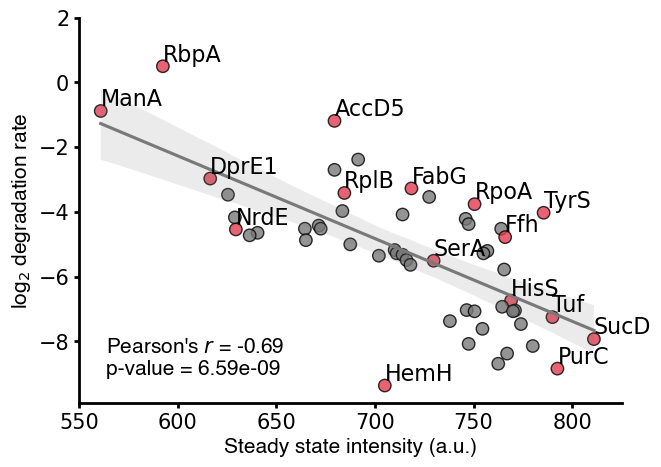

In [14]:
# Remove the negative control no substrate conditions
deg_stats_sub = deg_constant_list[(deg_constant_list['Substrate'] != 'No Target') & (~deg_constant_list['Strain'].str.startswith('Plate5'))].copy()


#Define subset of substrates to label

labels = ['RbpA', 'RpoA', 'TyrS', 'AccD5', 'HemH', 'Tuf', 
          'SucD', 'ManA', 'FabG', 'RplB', 'SerA', 'Ffh', 'NrdE', 'HisS', 'PurC', 'DprE1']

# Define a function to assign color based on the 'Substrate' column
def assign_color(row):
    if row['Substrate'] in labels:
        return np.array([225,60,80])/255
    else:
        return np.array([121,121,121])/255

# Apply the function to create a new 'Label' column
deg_stats_sub['Color'] = deg_stats_sub.apply(assign_color, axis=1)

color=np.array([121,121,121])/255

fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot()
g=sns.regplot(data=deg_stats_sub, x='T0+',y='log2(Deg constant)', color = color, scatter_kws={'ec':'black','facecolors':deg_stats_sub['Color'], 's':80},ax=ax)

ax.spines[['right', 'top']].set_visible(False)
ax.spines[:].set_linewidth(2)
ax.set_xlabel('Steady state intensity (a.u.)',fontsize=15, fontname='Helvetica', fontweight='bold')
ax.set_ylabel('log$_2$ degradation rate',fontsize=15, fontname='Helvetica', fontweight='bold')
ax.tick_params(width=2)


texts = []
for s,deg,ssi in deg_stats_sub[['Substrate','Deg constant','T0+']].values:
    if s in labels:
        texts.append(ax.text(ssi,np.log2(deg),s,fontsize=16,ha='left',va='bottom'))
#adjust_text(texts)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(550,825)
plt.ylim(-9.9,2)

correlation_coef, p_value = pearsonr(deg_stats_sub['T0+'], deg_stats_sub['log2(Deg constant)'])
p_value_sci = "{:.2e}".format(p_value)

text = f"Pearson's $r$ = {correlation_coef:.2f}\np-value = {p_value_sci}"
plt.text(0.05, 0.17, text, transform=ax.transAxes, fontsize=15, va='top', ha='left', fontname = 'Helvetica', fontweight='bold')


#plt.savefig('/Users/saz462/Desktop/ClpTAC/Experiments/202306_BacPROTAC_flow_finalrun/Figures/Degradation_correlation_Plate1-4_final.svg',bbox_inches='tight', dpi = 400)

### Plot decay for a subset of substrates

In [15]:
subset = ['RbpA',
          'AccD5',
          'SucD',
          'RplB',
          'DprE1',
          'AtpG',
          'NrdE',
          'RpoA',
          'TyrS',
          'AtpA',
          'AtpH',
          'SecA1',
          'PyrG',
          'ManA',
          'InhA',
          'EttA',
          'No Target'
         ]

substrate_stat_sub = deg_constant_list[deg_constant_list['Substrate'].isin(subset)].copy()

#Rename the substrate column for the control strain
substrate_stat_sub.loc[substrate_stat_sub['Substrate'] == 'No Target', 'Substrate'] = 'FKBP-eGFP'

Text(0, 0.5, 'Normalized fluorescence')

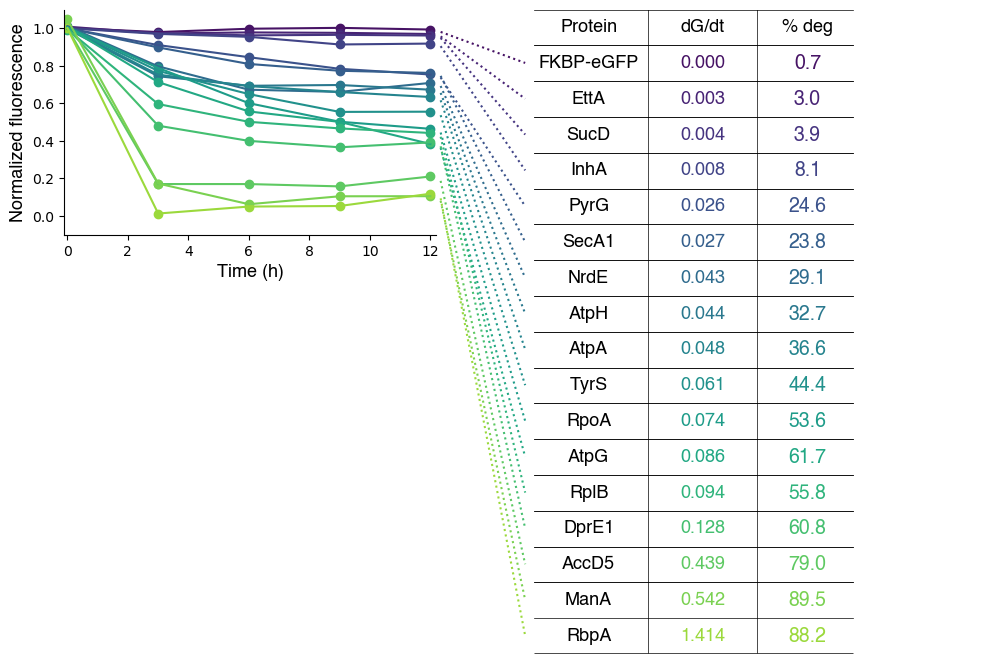

In [16]:
fig=plt.figure(figsize=(12,12))
grids = gs(20,10,wspace=0)
ax1=fig.add_subplot(grids[:5,:4])
ax2=fig.add_subplot(grids[:-6,4])
ax2.axis('off')
ax3=fig.add_subplot(grids[:-6,5:])
ax3.set_yticks([])
ax3.set_xticks([])
ax2.set_ylim(-0.34,2.1)
ax3.set_ylim(-0.34,2.1)
ax3_step = (2.1+0.34)/18
ax1.spines[['right', 'top']].set_visible(False)
ax3.spines[['left', 'right','top','bottom']].set_visible(False)
ax3.text(0.12,15*ax3_step,'Protein',va='center',ha='center',fontsize=13,fontname='Helvetica',fontweight='bold')
ax3.text(0.37,15*ax3_step,'dG/dt',va='center',ha='center',fontsize=13,fontname='Helvetica',fontweight='bold')
#ax3.text(0.37,15*ax3_step,'log$_{2}$(dG/dt)',va='center',ha='center',fontsize=13,fontname='Helvetica',fontweight='bold')
ax3.text(0.6,15*ax3_step,'% deg',va='center',ha='center',fontsize=13,fontname='Helvetica',fontweight='bold')


for i,k in enumerate(np.argsort(substrate_stat_sub['Deg constant'])):
    substrate,deg,log2deg,T0,T3,T6,T9,T12 = substrate_stat_sub[['Substrate','Deg constant','log2(Deg constant)','T0','T3','T6','T9','T12']].values[k]
    raw_deg = [T0,T3,T6,T9,T12]
    color = cm.viridis((i+1)/20)
    ax1.plot(np.array([0,3,6,9,12]),raw_deg,color=color)
    ax1.scatter(np.array([0,3,6,9,12]),raw_deg,color=color)
    ax2.plot([0,0.85],[raw_deg[-1]*0.72+1.3,(14-i)*ax3_step],color=color,ls=':')
    ax3.plot([0,0.7],[2.1-i*ax3_step,2.1-i*ax3_step],color='black',lw=0.5)
    ax3.text(0.12,(14-i)*ax3_step,substrate,va='center',ha='center',fontsize=13,fontname='Helvetica')
    ax3.text(0.37, (14 - i) * ax3_step, '{:.3f}'.format(deg), va='center', ha='center', fontsize=13, fontname='Helvetica', color=color)
    #ax3.text(0.37, (14 - i) * ax3_step, '{:.3f}'.format(log2deg), va='center', ha='center', fontsize=13, fontname='Helvetica', color=color)
    ax3.text(0.6,(14-i)*ax3_step,round((1-np.min(raw_deg[-1]))*100,1),va='center',ha='center',fontsize=14,fontname='Helvetica',color=color)
    ax3.plot([0,0.7],[2.1-(i+1)*ax3_step,2.1-(i+1)*ax3_step],color='black',lw=0.5)

ax3.vlines(0.25,-0.335,2.5,lw=0.5,color='black')
ax3.vlines(0.49,-0.335,2.5,lw=0.5,color='black')
ax3.hlines(-0.335,0,0.7,lw=0.5,color='black')
ax3.set_xlim(-0.01,1.01)
ax1.set_xlim(-0.1,12.2)
ax1.set_ylim(-0.1,1.1)
ax1.set_xlabel('Time (h)', fontname='Helvetica', fontsize = 13, fontweight='bold')
ax1.set_ylabel('Normalized fluorescence', fontname='Helvetica', fontsize = 13, fontweight='bold')
#plt.savefig('/Users/saz462/Desktop/ClpTAC/Experiments/202306_BacPROTAC_flow_finalrun/Figures/202402_Decay_fit_table_final.svg',bbox_inches='tight')
#plt.savefig('/Users/saz462/Desktop/ClpTAC/Figures/Source_figures/HW84_Updates/3cd_202402_Decay_fit_table_final.svg',bbox_inches='tight')


### Calculate PDFs

In [127]:
xinterp = np.linspace(400,1200,200)
pdfs = []
for k in grouped_median.index:
    v = filtered[filtered['Unique_id']==k]['AlexaFluor488-H'].values
    pdf = stats.gaussian_kde(v).pdf(xinterp)
    pdfs.append(pdf)
grouped_median['PDF'] = pdfs
pk.dump(grouped_median,open(src+'Notebooks/PDF_filtered_grouped_final.pk','wb'))

### Load PDFs

In [17]:
with open(src+'Notebooks/PDF_filtered_grouped_final.pk','rb') as file:
    grouped_median = pk.load(file)

### Plot individual flow charts

In [18]:
times = ['T0','T3','T6','T9','T12']
time_labels = ['0 hrs','3 hrs','6 hrs','9 hrs','12 hrs']
bg_color=np.array([40,40,40])/255
ctrl_color=np.array([121,121,121])/255
rapa_color=np.array([225,60,80])/255
vmin=450
xinterp = np.linspace(400,1200,200)

In [19]:
for substrate in deg_constant_list['Substrate'].unique():
    try:
        fig=plt.figure(figsize=(4,4))
        ax =fig.add_subplot()
        subset = grouped_median[(grouped_median['Substrate']==substrate)].copy()
        gname = subset['Substrate'].unique()[0]
        subset_date = subset['Date'].unique()[0]
        if subset_date != '2023-07-04':
            ctrl_plus = grouped_median[(grouped_median['Date']==subset_date)&\
                                        (grouped_median['Substrate']=='WT')&\
                                       (grouped_median['Rapa']=='Rapa')]
            ctrl_minus = grouped_median[(grouped_median['Date']==subset_date)&\
                                        (grouped_median['Substrate']=='WT')&\
                                       (grouped_median['Rapa']=='DMSO')]
        else:
            ctrl_plus = grouped_median[(grouped_median['Date']=='2023-07-01')&\
                                        (grouped_median['Substrate']=='WT')&\
                                       (grouped_median['Rapa']=='Rapa')]
            ctrl_minus = grouped_median[(grouped_median['Date']=='2023-07-01')&\
                                        (grouped_median['Substrate']=='WT')&\
                                       (grouped_median['Rapa']=='DMSO')]
  
        xinterp = np.linspace(400,1200,200)
        vmin = 400
        vmax = 900
        #vmin = 450
        #vmax = round(subset['AlexaFluor488-H'].max(),-2)+80
        
        plot_range = np.where((xinterp>vmin)&(xinterp<vmax))[0]
        sliced_x = xinterp[plot_range]
        for i,t in enumerate(times):
            for j,r in enumerate([1,2]):
                try:
                    rapa_plus = min_max(subset[(subset['Rapa']=='Rapa')&(subset['Time']==t)&(subset['Replicate']==r)]['PDF'].values[0])[plot_range]
                    rapa_minus = min_max(subset[(subset['Rapa']=='DMSO')&(subset['Time']==t)&(subset['Replicate']==r)]['PDF'].values[0])[plot_range]

                    ax.plot(sliced_x,rapa_minus+i*1.1,color=ctrl_color,zorder=3)
                    ax.fill_between(sliced_x,y1=np.zeros(len(sliced_x))+i*1.1,y2=rapa_minus+i*1.1,color=ctrl_color,alpha=0.2,zorder=3)
                    ax.plot(sliced_x,rapa_plus+i*1.1,color=rapa_color,zorder=2)
                    ax.fill_between(sliced_x,y1=np.zeros(len(sliced_x))+i*1.1,y2=rapa_plus+i*1.1,color=rapa_color,alpha=0.2,zorder=2)
                except:
                    print(substrate)

            ctrl1 = min_max(ctrl_minus[ctrl_minus['Time']==t]['PDF'].values[0])[plot_range]
            ctrl2 = min_max(ctrl_plus[ctrl_plus['Time']==t]['PDF'].values[0])[plot_range]
            ax.plot(sliced_x,ctrl1+i*1.1,color=bg_color,ls=':',zorder=1)
            ax.plot(sliced_x,ctrl2+i*1.1,color=bg_color,ls=':',zorder=1)
            ax.fill_between(sliced_x,y1=np.zeros(len(sliced_x))+i*1.1,
                            y2=ctrl1+i*1.1,color=bg_color,alpha=0.05)
            ax.fill_between(sliced_x,y1=np.zeros(len(sliced_x))+i*1.1,
                            y2=ctrl2+i*1.1,color=bg_color,alpha=0.05)
            ax.hlines(y=[i*1.1 for i in range(5)],xmin=vmin+1,xmax=vmax-1,color='w',zorder=5,lw=2)
            ax.hlines(y=[i*1.1 for i in range(5)],xmin=vmin,xmax=vmax,color='black',zorder=6,lw=1)
        ax.set_xlim(vmin,vmax)
        ax.set_yticks([])
        ax.set_xticklabels([int(x) for x in ax.get_xticks()],fontsize=16,fontname='Helvetica', fontweight='bold')
        for i in range(5):
            y = i*1.1+0.82
            x = vmin+(vmax-vmin)/40
            ax.text(x,y,time_labels[i],ha='left',va='center',fontsize=16,fontname='Helvetica', fontweight='bold')
        ax.set_title(substrate,fontsize=16,fontname='Helvetica', fontweight='bold')
        #plt.savefig(src+'Figures/202402_Flowcharts/{}_flowchart.svg'.format(gname),bbox_inches='tight')
        plt.close()
    except:
        print(substrate)

/var/folders/vd/jc39n3k17jz_k0s88p5l1xrw0000gn/T/ipykernel_7256/1037170300.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x) for x in ax.get_xticks()],fontsize=16,fontname='Helvetica', fontweight='bold')


### Plot all flow charts on a grid

/var/folders/vd/jc39n3k17jz_k0s88p5l1xrw0000gn/T/ipykernel_7256/3230310956.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_grid.set_xticklabels([int(x) for x in ax_grid.get_xticks()],fontsize=14,fontname='Helvetica', fontweight='bold')


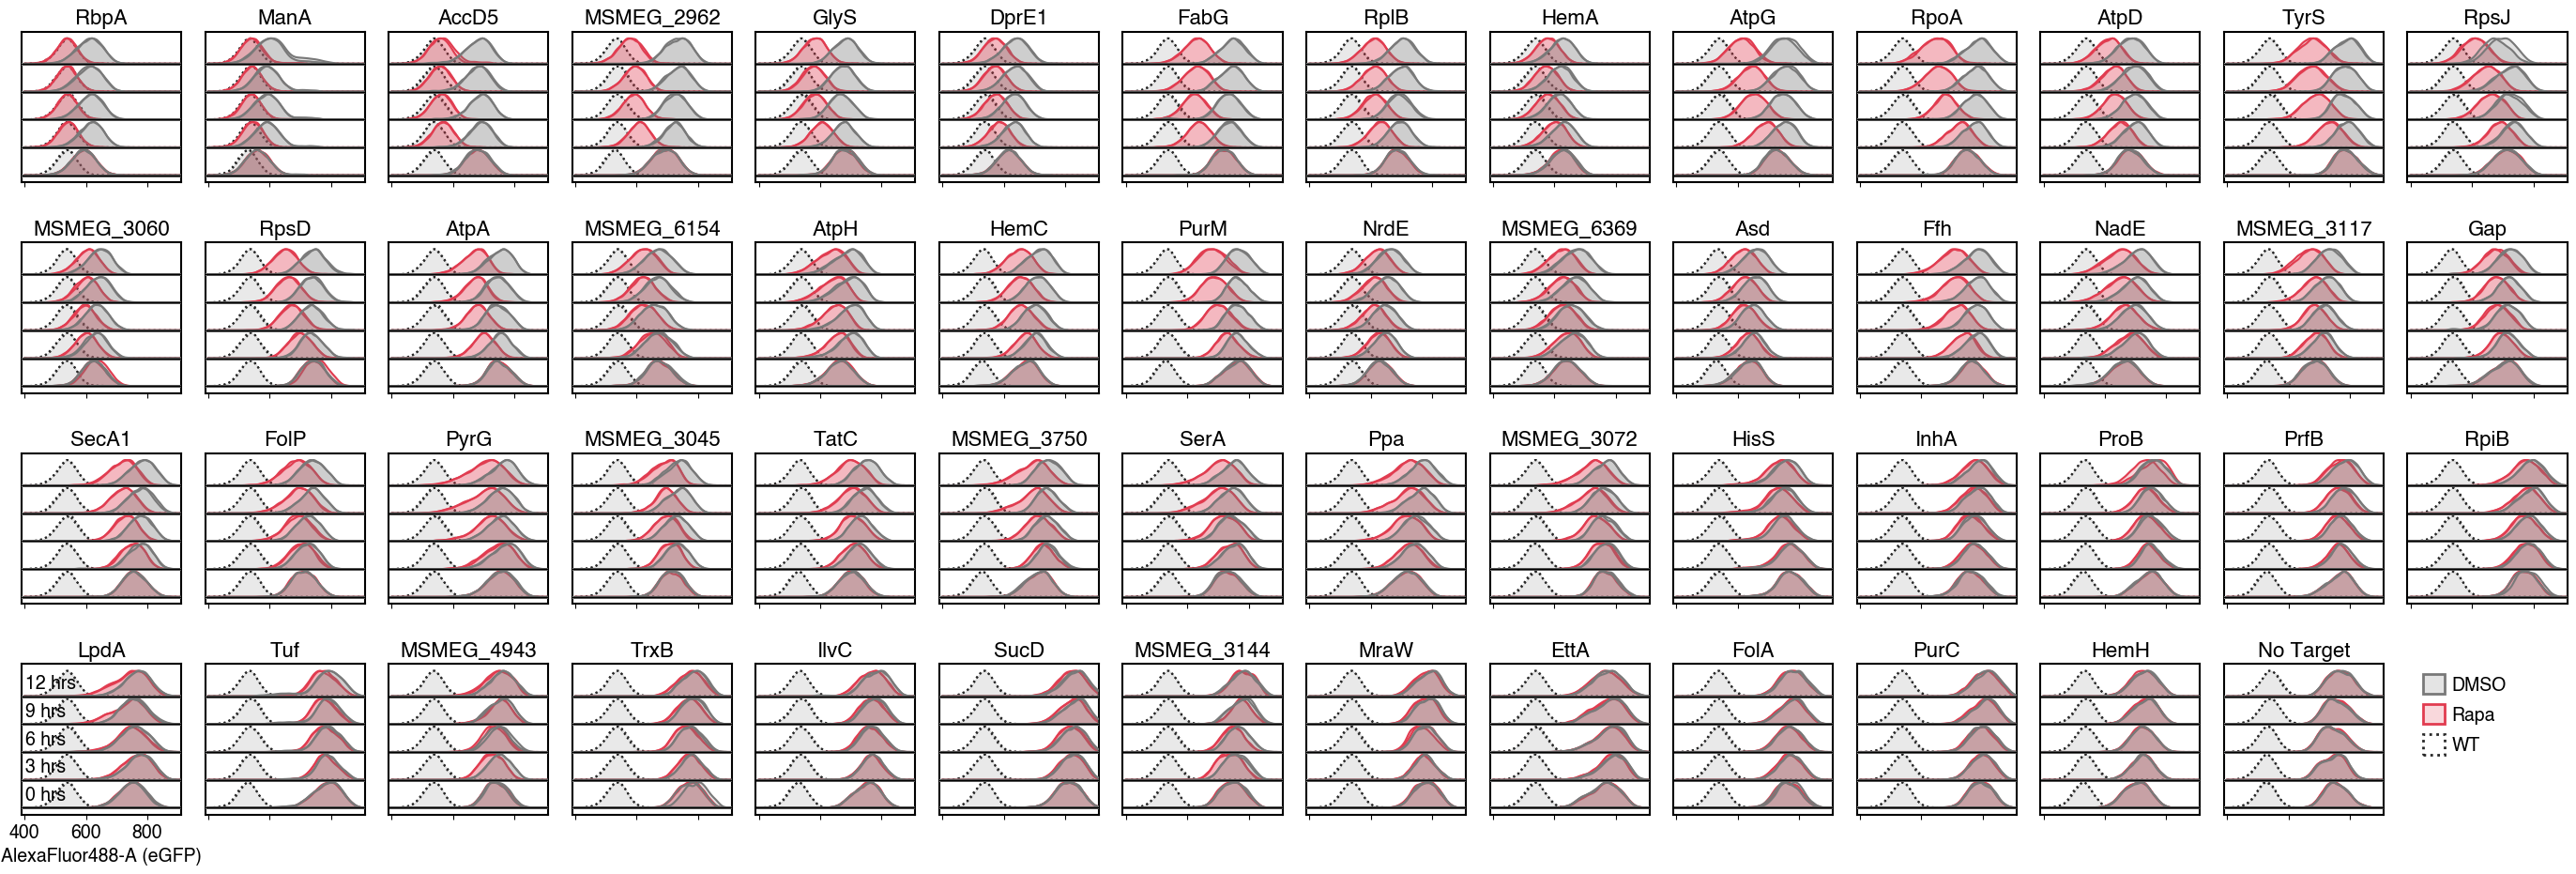

In [20]:
fig_grid=plt.figure(figsize=(35,40))
grids=gs(14,14,hspace=0.4,wspace=0.15)

for z,substrate in enumerate(deg_constant_list_sub['Substrate'].unique()):
    
    # Determine row and column in grid
    row,col = (z//14),z%14
    ax_grid=fig_grid.add_subplot(grids[row,col])
    
    try:
        subset = grouped_median[(grouped_median['Substrate']==substrate)].copy()
        gname = subset['Substrate'].unique()[0]
        subset_date = subset['Date'].unique()[0]
        if subset_date != '2023-07-04':
            ctrl_plus = grouped_median[(grouped_median['Date']==subset_date)&\
                                        (grouped_median['Substrate']=='WT')&\
                                       (grouped_median['Rapa']=='Rapa')]
            ctrl_minus = grouped_median[(grouped_median['Date']==subset_date)&\
                                        (grouped_median['Substrate']=='WT')&\
                                       (grouped_median['Rapa']=='DMSO')]
        else:
            ctrl_plus = grouped_median[(grouped_median['Date']=='2023-07-01')&\
                                        (grouped_median['Substrate']=='WT')&\
                                       (grouped_median['Rapa']=='Rapa')]
            ctrl_minus = grouped_median[(grouped_median['Date']=='2023-07-01')&\
                                        (grouped_median['Substrate']=='WT')&\
                                       (grouped_median['Rapa']=='DMSO')]
  
        xinterp = np.linspace(400,1200,200)
        vmin = 390
        vmax = 910
        #vmin = 450
        #vmax = round(subset['AlexaFluor488-H'].max(),-2)+80
        
        plot_range = np.where((xinterp>vmin)&(xinterp<vmax))[0]
        sliced_x = xinterp[plot_range]
        for i,t in enumerate(times):
            for j,r in enumerate([1,2]):
                try:
                    rapa_plus = min_max(subset[(subset['Rapa']=='Rapa')&(subset['Time']==t)&(subset['Replicate']==r)]['PDF'].values[0])[plot_range]
                    rapa_minus = min_max(subset[(subset['Rapa']=='DMSO')&(subset['Time']==t)&(subset['Replicate']==r)]['PDF'].values[0])[plot_range]
                    
                    ax_grid.plot(sliced_x,rapa_minus+i*1.1,color=ctrl_color,zorder=3)
                    ax_grid.fill_between(sliced_x,y1=np.zeros(len(sliced_x))+i*1.1,y2=rapa_minus+i*1.1,color=ctrl_color,alpha=0.2,zorder=3)
                    ax_grid.plot(sliced_x,rapa_plus+i*1.1,color=rapa_color,zorder=2)
                    ax_grid.fill_between(sliced_x,y1=np.zeros(len(sliced_x))+i*1.1,y2=rapa_plus+i*1.1,color=rapa_color,alpha=0.2,zorder=2)
                    
                except:
                    print(substrate)

            ctrl1 = min_max(ctrl_minus[ctrl_minus['Time']==t]['PDF'].values[0])[plot_range]
            ctrl2 = min_max(ctrl_plus[ctrl_plus['Time']==t]['PDF'].values[0])[plot_range]
            
            ax_grid.plot(sliced_x,ctrl1+i*1.1,color=bg_color,ls=':',zorder=1)
            ax_grid.plot(sliced_x,ctrl2+i*1.1,color=bg_color,ls=':',zorder=1)
            ax_grid.fill_between(sliced_x,y1=np.zeros(len(sliced_x))+i*1.1,
                            y2=ctrl1+i*1.1,color=bg_color,alpha=0.05)
            ax_grid.fill_between(sliced_x,y1=np.zeros(len(sliced_x))+i*1.1,
                            y2=ctrl2+i*1.1,color=bg_color,alpha=0.05)
            ax_grid.hlines(y=[i*1.1 for i in range(5)],xmin=vmin+1,xmax=vmax-1,color='w',zorder=5,lw=2)
            ax_grid.hlines(y=[i*1.1 for i in range(5)],xmin=vmin,xmax=vmax,color='black',zorder=6,lw=1)
            
        
        ax_grid.set_xlim(vmin,vmax)
        ax_grid.set_yticks([])
        ax_grid.set_title(substrate,fontsize=16,fontname='Helvetica', fontweight='bold')
        
        if row==3 and col==0:
            ax_grid.set_xticklabels([int(x) for x in ax_grid.get_xticks()],fontsize=14,fontname='Helvetica', fontweight='bold')
            ax_grid.set_xlabel('AlexaFluor488-A (eGFP)',fontsize=14,fontname='Helvetica', fontweight='bold')
            #ax_grid.set_ylabel('Normalized to mode',fontsize=14,fontname='Helvetica', fontweight='bold')
            for i in range(5):
                y = i*1.1+0.5
                x = vmin+(vmax-vmin)/40
                ax_grid.text(x,y,time_labels[i],ha='left',va='center',fontsize=14,fontname='Helvetica', fontweight='bold')      
       
        else:
            ax_grid.set_xticklabels([])

        #set the axis spine linewidth
        ax_grid.spines[:].set_linewidth(1.5)
    
            
    except:
        print(substrate)
        


#Add legend to empty space 
legend_ax=fig_grid.add_subplot(grids[3,13])
legend_ax.set_xticks([])
legend_ax.set_yticks([])
legend_ax.spines[:].set_visible(False)
legend_ax.set_xlim(0, 10)
legend_ax.set_ylim(0, 10)

legend_props = [
    {'label': 'DMSO', 'line_type': '-', 'line_color': ctrl_color, 'fill_color': ctrl_color, 'alpha': 0.2},
    {'label': 'Rapa', 'line_type': '-', 'line_color': rapa_color, 'fill_color': rapa_color, 'alpha': 0.2},
    {'label': 'WT', 'line_type': ':', 'line_color': bg_color, 'fill_color': 'none', 'alpha': 1}]

x, y = 1, 8
for square in legend_props:
    square_fill = plt.Rectangle((x, y), 1.333, 1.333, linewidth=.1, linestyle=square['line_type'], edgecolor=square['line_color'], facecolor=square['fill_color'], alpha=0.2)
    square_patch = plt.Rectangle((x, y), 1.333, 1.333, linewidth=2, linestyle=square['line_type'], edgecolor=square['line_color'], facecolor='none')
    legend_ax.add_patch(square_fill)
    legend_ax.add_patch(square_patch)
    legend_ax.text(x + 1.75, y + 0.25, square['label'], fontsize=14,fontname='Helvetica', fontweight='bold')
    y -= 2

#plt.savefig('/Users/saz462/Desktop/ClpTAC/Figures/Source_figures/HW84_Updates/S7c_20240216_Training_flowcharts_final.svg',bbox_inches='tight')


### Generate line plots and flow charts for 18 validation substrates

In [21]:
#Define subset 
deg_constant_list_val = deg_constant_list[deg_constant_list['Strain'].str.contains('Plate5')]

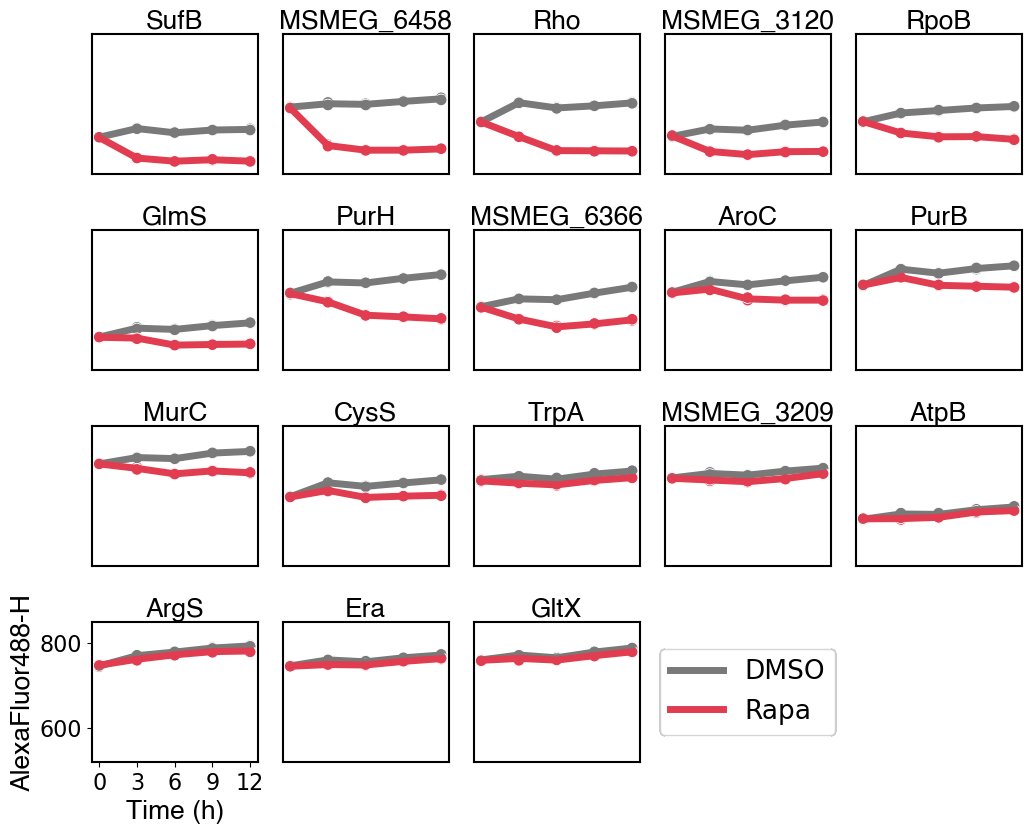

In [22]:
lw = 5
ps = 70
fs = 19

fig=plt.figure(figsize=(12,12))
grids= gs(5,5,hspace=0.4,wspace=0.15)
colors = [np.array([121, 121, 121])/255, np.array([225, 60, 80])/255] #red and gray

for i,k in enumerate(deg_constant_list_val['Substrate'].unique()):
        
        # Determine row and column in grid
        r,c = (i//5),i%5
        ax=fig.add_subplot(grids[r,c])

        # Set the axis spine linewidth
        ax.spines[:].set_linewidth(1.5)

        # Define data based on substrate and define the No Target replicate to use
        data = grouped_median[grouped_median['Substrate'] == k].copy()


        # only label the bottom left panel 
        if r==3 and c==0:
            sns.lineplot(ax=ax, data=data, x='Time numeric', y='AlexaFluor488-H', hue='Rapa', palette=colors, lw=lw, legend=False)
            sns.scatterplot(ax=ax, data=data, x='Time numeric', y='AlexaFluor488-H', hue='Rapa', palette=colors, legend=False, s=ps)
            ax.set_xlabel('Time (h)',fontsize=fs,fontname='Helvetica', fontweight='bold')
            ax.set_xticks([0,3,6,9,12])
            ax.set_ylabel('AlexaFluor488-H',fontsize=fs, fontname='Helvetica',fontweight='bold')
            ax.tick_params(axis='both', which='major', labelsize=16)


        else:
            sns.lineplot(ax=ax, data=data, x='Time numeric', y='AlexaFluor488-H', hue='Rapa', palette=colors, lw=lw, legend=False)
            sns.scatterplot(ax=ax, data=data, x='Time numeric', y='AlexaFluor488-H', hue='Rapa', palette=colors, legend=False, s=ps)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_xlabel('')
            ax.set_ylabel('')

        ax.set_title(k,va='top',fontsize=fs,fontname='Helvetica', fontweight='bold')
        ax.set_ylim(520, 850)
        ax.set_axis_off
        

        #add legend to empty space 
        legend_ax=fig.add_subplot(grids[3,3])
        legend_ax.set_xticks([])
        legend_ax.set_yticks([])
        legend_ax.plot([],[],color=colors[0],ls='-',lw=lw, label='DMSO')
        legend_ax.plot([],[],color=colors[1],ls='-',lw=lw, label='Rapa')
        legend_ax.legend(loc="center", fontsize=fs)
        legend_ax.spines[:].set_visible(False)

#fig.savefig('/Users/saz462/Desktop/Final_figures/S10/Lineplots_validation_final_20240126.svg', bbox_inches='tight')

/var/folders/vd/jc39n3k17jz_k0s88p5l1xrw0000gn/T/ipykernel_7256/4209006663.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_grid.set_xticklabels([int(x) for x in ax_grid.get_xticks()],fontsize=14,fontname='Helvetica', fontweight='bold')


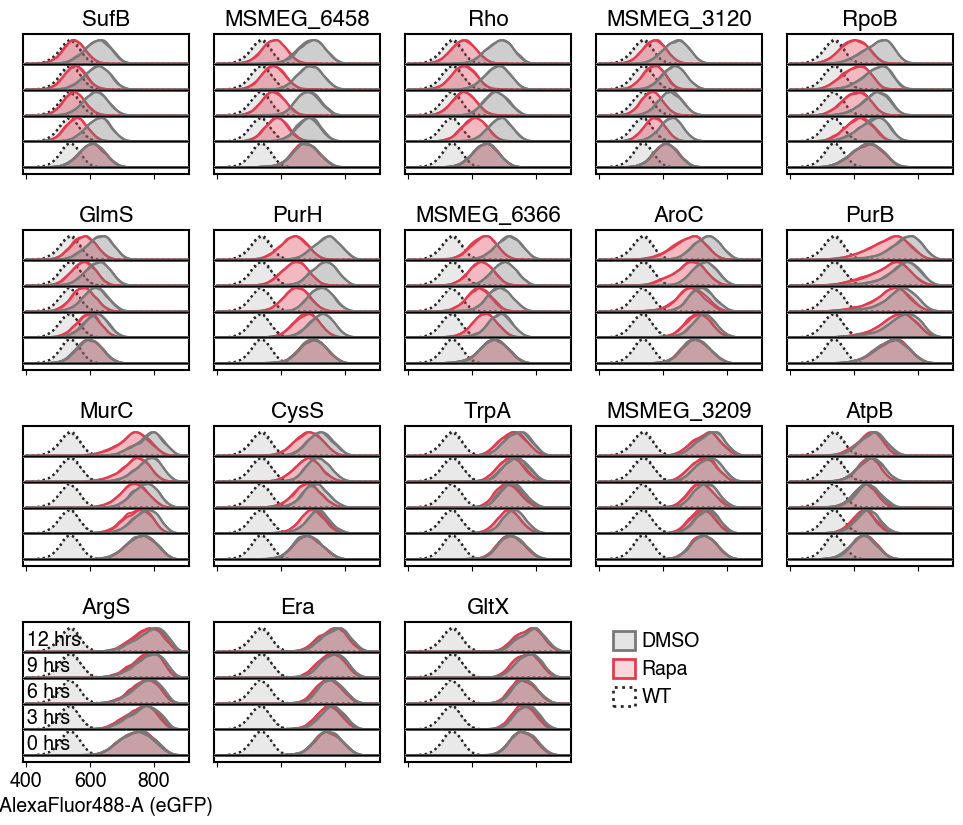

In [23]:
fig_grid=plt.figure(figsize=(12,12))
grids=gs(5,5,hspace=0.4,wspace=0.15)

for z,substrate in enumerate(deg_constant_list_val['Substrate'].unique()):
    
    # Determine row and column in grid
    row,col = (z//5),z%5
    ax_grid=fig_grid.add_subplot(grids[row,col])
    
    try:
        subset = grouped_median[(grouped_median['Substrate']==substrate)].copy()
        gname = subset['Substrate'].unique()[0]
        subset_date = subset['Date'].unique()[0]
        if subset_date != '2023-07-04':
            ctrl_plus = grouped_median[(grouped_median['Date']==subset_date)&\
                                        (grouped_median['Substrate']=='WT')&\
                                       (grouped_median['Rapa']=='Rapa')]
            ctrl_minus = grouped_median[(grouped_median['Date']==subset_date)&\
                                        (grouped_median['Substrate']=='WT')&\
                                       (grouped_median['Rapa']=='DMSO')]
        else:
            ctrl_plus = grouped_median[(grouped_median['Date']=='2023-07-01')&\
                                        (grouped_median['Substrate']=='WT')&\
                                       (grouped_median['Rapa']=='Rapa')]
            ctrl_minus = grouped_median[(grouped_median['Date']=='2023-07-01')&\
                                        (grouped_median['Substrate']=='WT')&\
                                       (grouped_median['Rapa']=='DMSO')]
  
        xinterp = np.linspace(400,1200,200)
        vmin = 390
        vmax = 910
        #vmin = 450
        #vmax = round(subset['AlexaFluor488-H'].max(),-2)+80
        
        plot_range = np.where((xinterp>vmin)&(xinterp<vmax))[0]
        sliced_x = xinterp[plot_range]
        for i,t in enumerate(times):
            for j,r in enumerate([1,2]):
                try:
                    rapa_plus = min_max(subset[(subset['Rapa']=='Rapa')&(subset['Time']==t)&(subset['Replicate']==r)]['PDF'].values[0])[plot_range]
                    rapa_minus = min_max(subset[(subset['Rapa']=='DMSO')&(subset['Time']==t)&(subset['Replicate']==r)]['PDF'].values[0])[plot_range]
                    
                    ax_grid.plot(sliced_x,rapa_minus+i*1.1,color=ctrl_color,zorder=3)
                    ax_grid.fill_between(sliced_x,y1=np.zeros(len(sliced_x))+i*1.1,y2=rapa_minus+i*1.1,color=ctrl_color,alpha=0.2,zorder=3)
                    ax_grid.plot(sliced_x,rapa_plus+i*1.1,color=rapa_color,zorder=2)
                    ax_grid.fill_between(sliced_x,y1=np.zeros(len(sliced_x))+i*1.1,y2=rapa_plus+i*1.1,color=rapa_color,alpha=0.2,zorder=2)
                    
                except:
                    print(substrate)

            ctrl1 = min_max(ctrl_minus[ctrl_minus['Time']==t]['PDF'].values[0])[plot_range]
            ctrl2 = min_max(ctrl_plus[ctrl_plus['Time']==t]['PDF'].values[0])[plot_range]
            
            ax_grid.plot(sliced_x,ctrl1+i*1.1,color=bg_color,ls=':',zorder=1)
            ax_grid.plot(sliced_x,ctrl2+i*1.1,color=bg_color,ls=':',zorder=1)
            ax_grid.fill_between(sliced_x,y1=np.zeros(len(sliced_x))+i*1.1,
                            y2=ctrl1+i*1.1,color=bg_color,alpha=0.05)
            ax_grid.fill_between(sliced_x,y1=np.zeros(len(sliced_x))+i*1.1,
                            y2=ctrl2+i*1.1,color=bg_color,alpha=0.05)
            ax_grid.hlines(y=[i*1.1 for i in range(5)],xmin=vmin+1,xmax=vmax-1,color='w',zorder=5,lw=2)
            ax_grid.hlines(y=[i*1.1 for i in range(5)],xmin=vmin,xmax=vmax,color='black',zorder=6,lw=1)
            
        
        ax_grid.set_xlim(vmin,vmax)
        ax_grid.set_yticks([])
        ax_grid.set_title(substrate,fontsize=16,fontname='Helvetica', fontweight='bold')
        
        if row==3 and col==0:
            ax_grid.set_xticklabels([int(x) for x in ax_grid.get_xticks()],fontsize=14,fontname='Helvetica', fontweight='bold')
            ax_grid.set_xlabel('AlexaFluor488-A (eGFP)',fontsize=14,fontname='Helvetica', fontweight='bold')
            #ax_grid.set_ylabel('Normalized to mode',fontsize=14,fontname='Helvetica', fontweight='bold')
            for i in range(5):
                y = i*1.1+0.5
                x = vmin+(vmax-vmin)/40
                ax_grid.text(x,y,time_labels[i],ha='left',va='center',fontsize=14,fontname='Helvetica', fontweight='bold')      
       
        else:
            ax_grid.set_xticklabels([])

        #set the axis spine linewidth
        ax_grid.spines[:].set_linewidth(1.5)
    
            
    except:
        print(substrate)
        


#Add legend to empty space 
legend_ax=fig_grid.add_subplot(grids[3,3])
legend_ax.set_xticks([])
legend_ax.set_yticks([])
legend_ax.spines[:].set_visible(False)
legend_ax.set_xlim(0, 10)
legend_ax.set_ylim(0, 10)

legend_props = [
    {'label': 'DMSO', 'line_type': '-', 'line_color': ctrl_color, 'fill_color': ctrl_color, 'alpha': 0.2},
    {'label': 'Rapa', 'line_type': '-', 'line_color': rapa_color, 'fill_color': rapa_color, 'alpha': 0.2},
    {'label': 'WT', 'line_type': ':', 'line_color': bg_color, 'fill_color': 'none', 'alpha': 1}]

x, y = 1, 8
for square in legend_props:
    square_fill = plt.Rectangle((x, y), 1.333, 1.333, linewidth=.1, linestyle=square['line_type'], edgecolor=square['line_color'], facecolor=square['fill_color'], alpha=0.2)
    square_patch = plt.Rectangle((x, y), 1.333, 1.333, linewidth=2, linestyle=square['line_type'], edgecolor=square['line_color'], facecolor='none')
    legend_ax.add_patch(square_fill)
    legend_ax.add_patch(square_patch)
    legend_ax.text(x + 1.75, y + 0.25, square['label'], fontsize=14,fontname='Helvetica', fontweight='bold')
    y -= 2

#plt.savefig('/Users/saz462/Desktop/Final_figures/S10/Flowcharts_validation_final_20240126.svg',bbox_inches='tight')
